In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

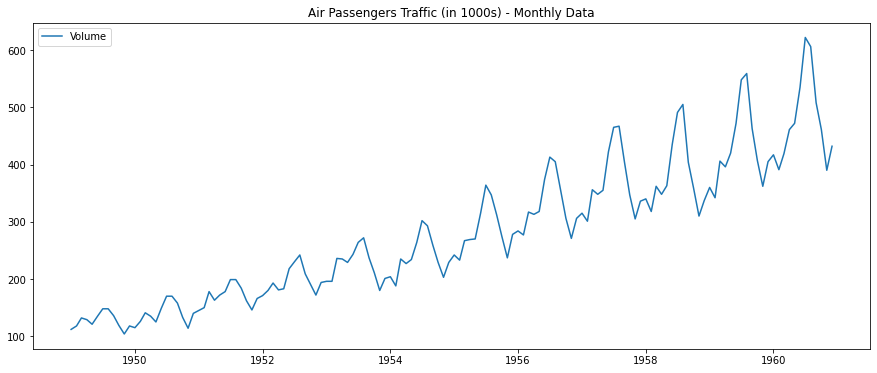

In [2]:
dateparser = lambda dates: datetime.strptime(dates,"%Y-%m")
df = pd.read_csv('data.csv',parse_dates=['Month'],index_col='Month',date_parser=dateparser)
df.columns = ['Volume'] # AirPassengers count is labelled as Volume for convinience sake.

plt.figure(figsize=(15,6))
plt.plot(df,label='Volume')
plt.legend()
plt.title("Air Passengers Traffic (in 1000s) - Monthly Data")
plt.show()

###  Triple Exponential Smoothing Method

After a look at above series, the only method i could easily think of is Triple Exponential Smoothing Method.. aka Holt's Winter Method.<br>
I can use Double Exponential method as well, but i'll have to remove seasonality first.


In [3]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [4]:
model1 = ExponentialSmoothing(df,trend='add',seasonal='mul',seasonal_periods=12)
model1_fit=model1.fit()

F:\anaconda\environments\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [5]:
model1.params

{'smoothing_level': 0.3185898660259786,
 'smoothing_trend': 2.382517469297811e-09,
 'smoothing_seasonal': 0.6013524400244354,
 'damping_trend': nan,
 'initial_level': 197.62286615433473,
 'initial_trend': 4.646997623764819,
 'initial_seasons': array([0.55084182, 0.57930085, 0.63970012, 0.6102315 , 0.56967126,
        0.62211857, 0.67648936, 0.66818491, 0.60919276, 0.53142518,
        0.4705981 , 0.53898757]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

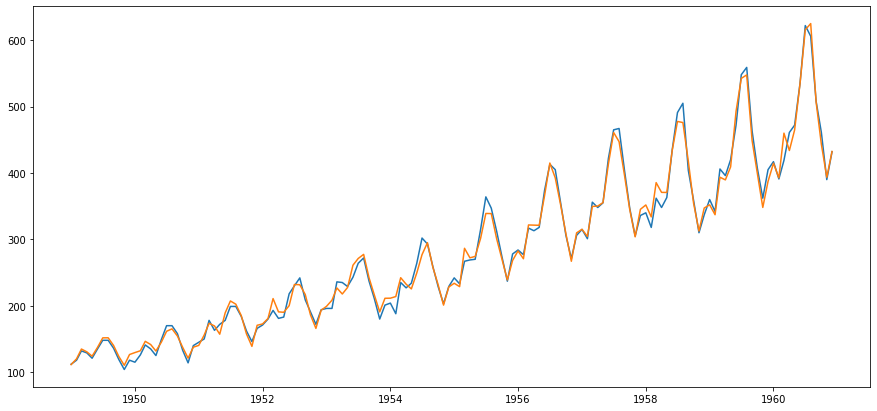

In [6]:
plt.figure(figsize=(15,7))
plt.plot(df)
plt.plot(model1_fit.fittedvalues)
plt.show()

In [7]:
pred = pd.DataFrame(model1_fit.forecast(steps=100))
pred.index = list(range(len(df),len(df)+100))
pred.head()

,0
144,445.242731
145,418.225788
146,465.310384
147,494.952052
148,505.476789


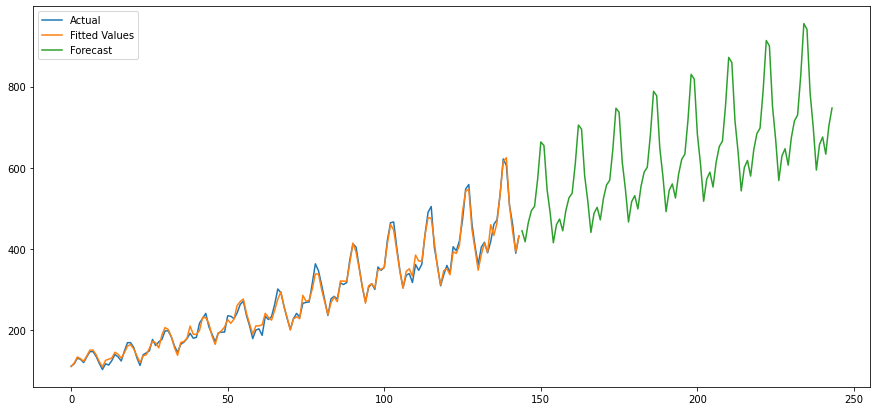

In [8]:
plt.figure(figsize=(15,7))
plt.plot(df.Volume.values,label='Actual')
plt.plot(model1_fit.fittedvalues.values,label='Fitted Values')
plt.plot(pred,label='Forecast')
plt.legend()
plt.show()

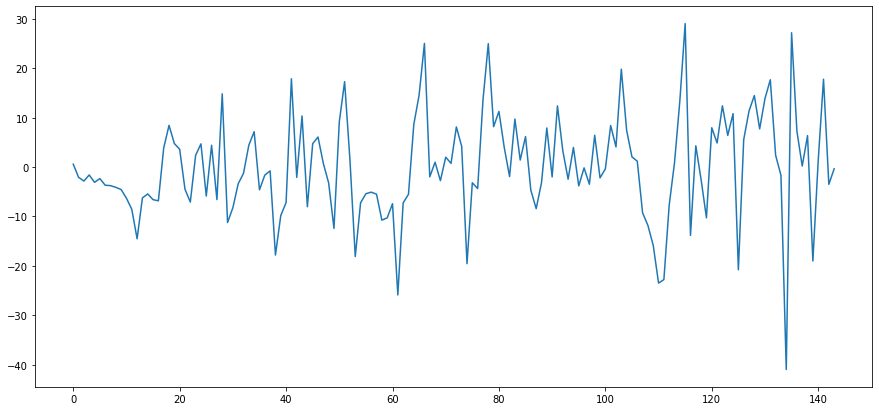

In [9]:
plt.figure(figsize=(15,7))
plt.plot(model1_fit.resid.values)
plt.show()

(array([ 1.,  0.,  4.,  7., 23., 47., 34., 19.,  5.,  4.]),
 array([-40.96314019, -33.96267149, -26.9622028 , -19.9617341 ,
        -12.9612654 ,  -5.96079671,   1.03967199,   8.04014068,
         15.04060938,  22.04107808,  29.04154677]),
 <BarContainer object of 10 artists>)

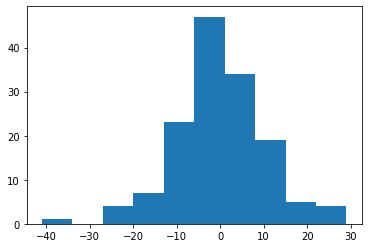

In [10]:
plt.hist(model1_fit.resid.values)

### ARIMA Model

We have a non-stationary series.. <br>
Let me confirm that using a plot and ADF test as well.

In [11]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries,include_mean=True,include_std=False):
    """
        Function to display rolling mean, rolling std and perform Augmented Dicky Fuller Test..
    """
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(15,7))
    actual=plt.plot(timeseries, label='Actual')
    if include_mean:
        mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    if include_std:
        std_6=plt.plot(rolstd, color='black', label='Rolling Std')
        
    plt.legend(loc='best')
    plt.title('Checking for Stationarity')
    plt.show()
    
    print('DF Test : ')
    dftest=adfuller(timeseries['Volume'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

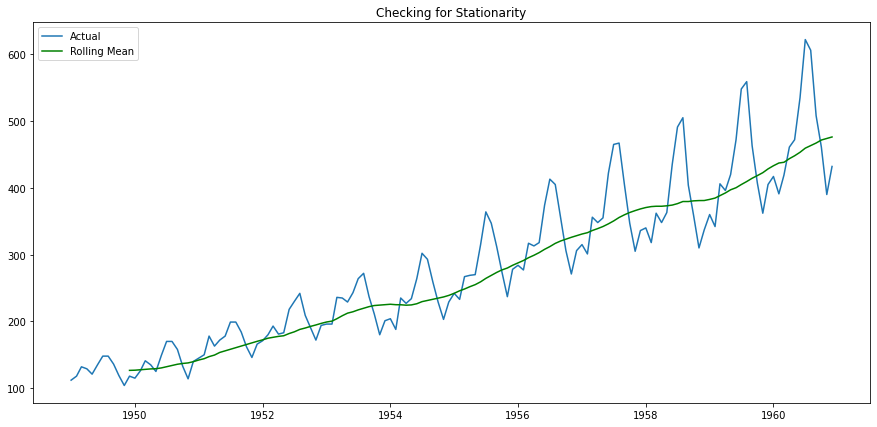

DF Test : 
Test Statistic            0.815369
p-value                   0.991880
Lags Used                13.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [12]:
check_stationarity(df)


<b>Note:</b><br>
Observe that p-value is lot higher than 0.05. We failed to reject null hypothesis.<br>
There is an unit root present in the series. Hence series is non stationary.. 


### Make the series stationary.

Now, we have to make series stationary. <br>
There are various methods to do.. We will examine one by one..

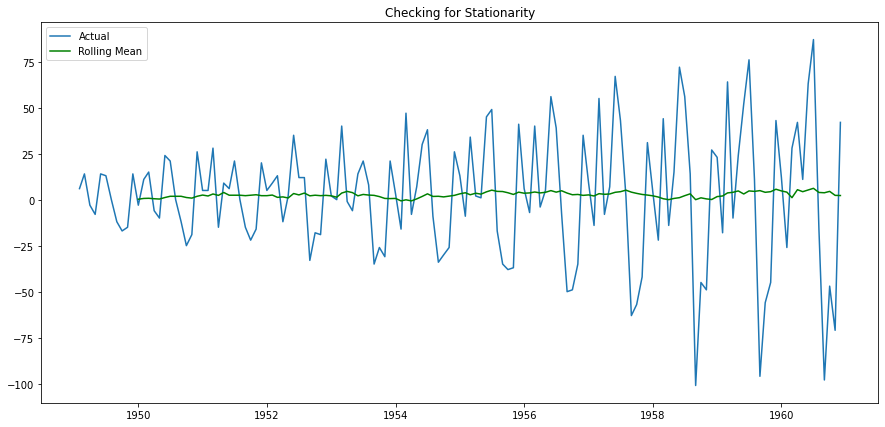

DF Test : 
Test Statistic           -2.829267
p-value                   0.054213
Lags Used                12.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [13]:
first_diff = df -df.shift(1)
check_stationarity(first_diff.dropna())

First Differencing didnt work out, as  p-value is 0.054213.<br>
Series is still non-stationary. Let's try log-transformation.

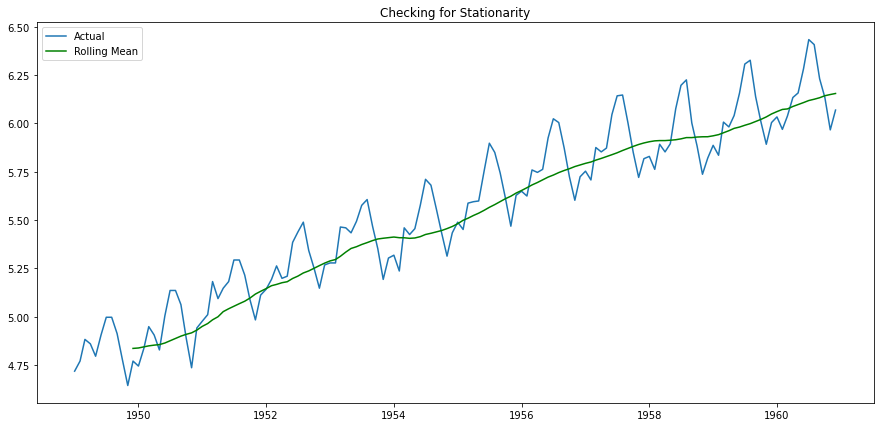

DF Test : 
Test Statistic           -1.717017
p-value                   0.422367
Lags Used                13.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [14]:
log_df = np.log(df)
check_stationarity(log_df) 

Log-Transformation also didnt work out. Series is still non stationary.

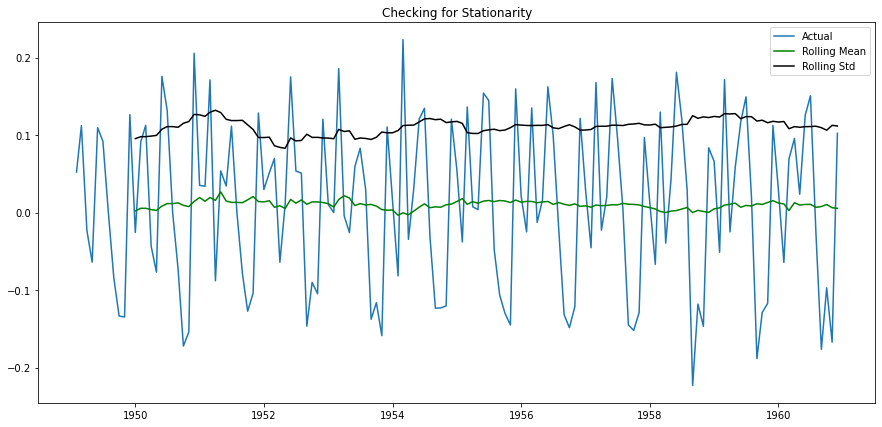

DF Test : 
Test Statistic           -2.717131
p-value                   0.071121
Lags Used                14.000000
No. of Obs              128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


In [15]:
df_log_first = log_df - log_df.shift(1)
check_stationarity(df_log_first.dropna(),include_std=True)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. 

Okay.. I'll stop here for looking more possible stationary series.<br>
Let's dive into next step.. i.e., ACF and PACF plots.. to determine p,q values which are required in the ARIMA model.

In [16]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def plot_acf_pacf(y, lags=None, figsize=(15,4)):
    """
        Plot ACF and PACF
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context('bmh'):    
        fig = plt.figure(figsize=figsize)
        layout = (1, 2)
        
        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
        
        #y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

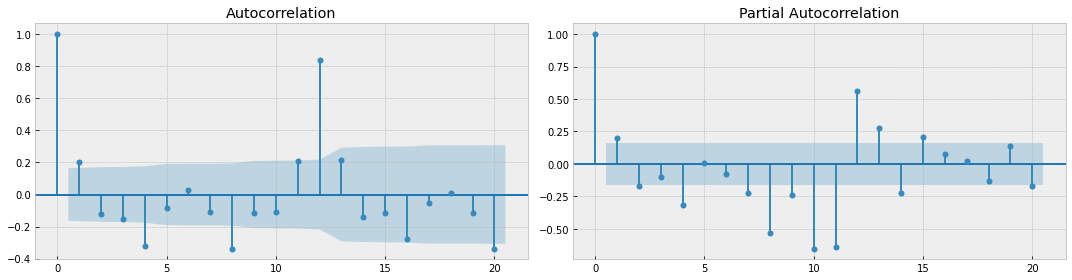

In [17]:
plot_acf_pacf(df_log_first.Volume.dropna(),lags=20) # We can see that p=2 and q=1

#### ARIMA MODELLING

In [18]:
from statsmodels.tsa.arima_model import ARIMA

In [19]:
model2 = ARIMA(log_df.dropna(),order=(2,1,2))
model2_fit = model2.fit(disp=-1)

F:\anaconda\environments\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
F:\anaconda\environments\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


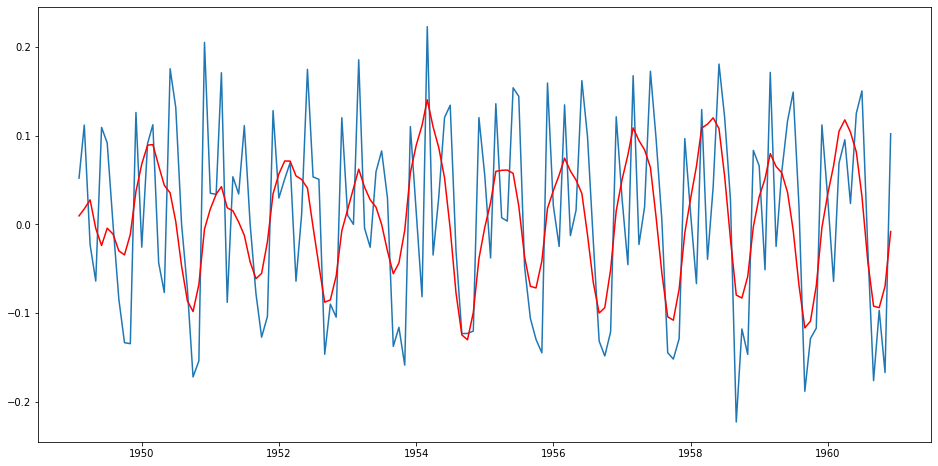

In [20]:
fig = plt.figure(figsize=(16,8))
plt.plot(df_log_first)
plt.plot(model2_fit.fittedvalues,color='red')
plt.show()

In [21]:
fitted_vals_cum_sum = model2_fit.fittedvalues.cumsum()
fitted_vals_log = pd.Series(log_df.Volume.iloc[0],index= log_df.index)
fitted_vals_log=fitted_vals_log.add(fitted_vals_cum_sum,fill_value=0)
fitted_vals_exp = np.exp(fitted_vals_log)

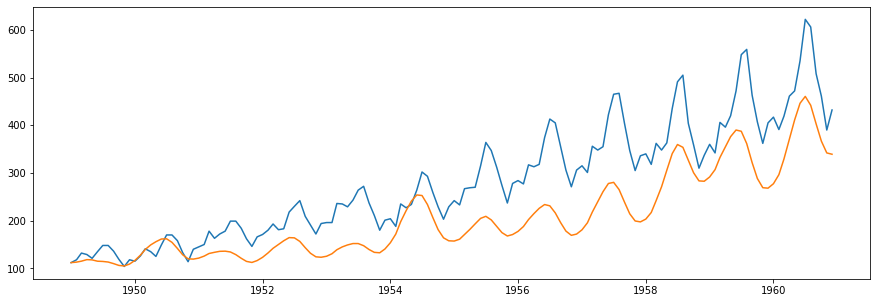

In [22]:
plt.figure(figsize=(15,5))
plt.plot(df)
plt.plot(fitted_vals_exp)
plt.show()

In [23]:
x = np.exp(model2_fit.forecast(steps=100)[0])
x_df = pd.DataFrame(x)
x_df.index = list(range(144,144+100))
x_df.head()

,0
144,443.870919
145,470.038121
146,504.934833
147,540.454659
148,567.730579


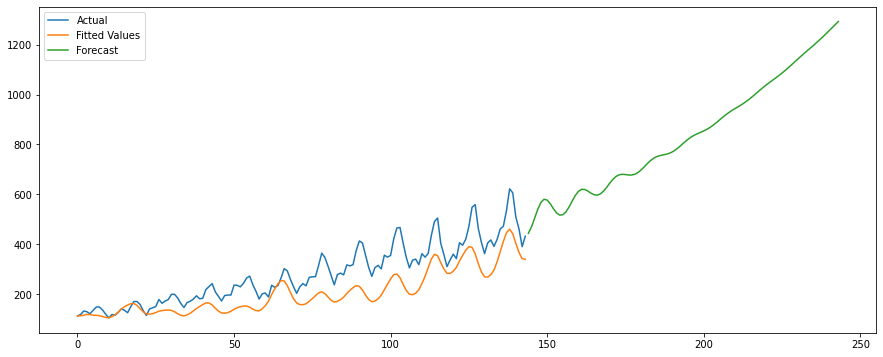

In [24]:
plt.figure(figsize=(15,6))
plt.plot(df.Volume.values,label='Actual')
plt.plot(fitted_vals_exp.values,label='Fitted Values')
plt.plot(x_df,label='Forecast')
plt.legend()
plt.show()

It is not performing .. well.. <br>
This was kind of expected though. 

## SARIMA MODEL

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

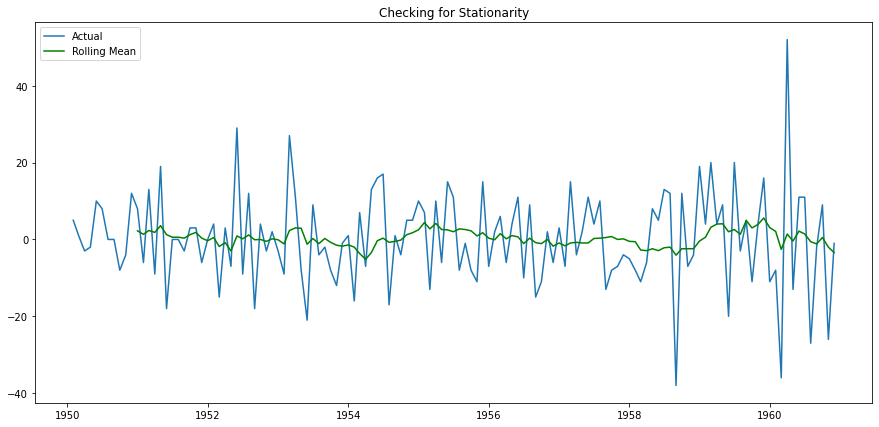

DF Test : 
Test Statistic         -1.559562e+01
p-value                 1.856512e-28
Lags Used               0.000000e+00
No. of Obs              1.300000e+02
Critical Value (1%)    -3.481682e+00
Critical Value (5%)    -2.884042e+00
Critical Value (10%)   -2.578770e+00
dtype: float64


In [26]:
df_diff = first_diff - first_diff.shift(12)
check_stationarity(df_diff.dropna())

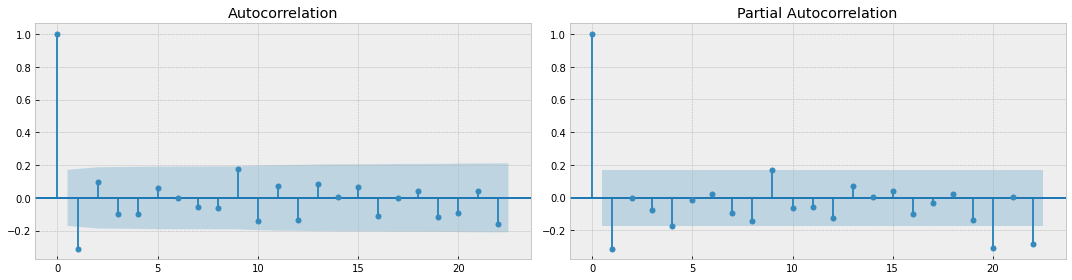

In [27]:
plot_acf_pacf(df_diff.Volume.dropna())

In [28]:
model3 =  SARIMAX(df,order=(1,1,1),seasonal_order=(0,1,0,12))
model3_fit = model3.fit()

F:\anaconda\environments\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
F:\anaconda\environments\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [29]:
pred = model3_fit.predict(start=len(df), end=len(df)+100)

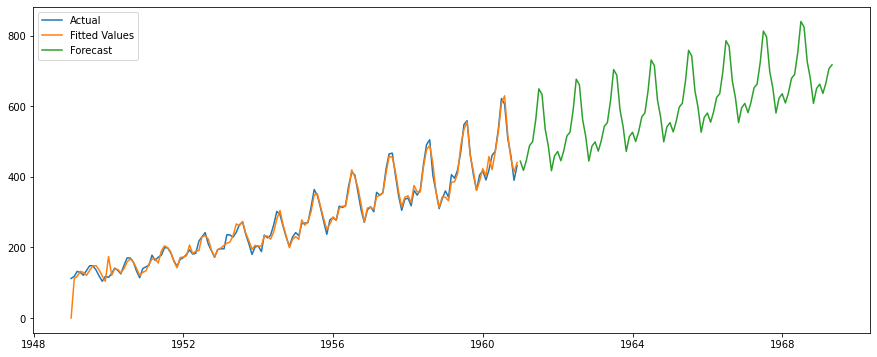

In [30]:
plt.figure(figsize=(15,6))
plt.plot(df,label='Actual')
plt.plot(model3_fit.fittedvalues,label='Fitted Values')
plt.plot(pred,label='Forecast')
plt.legend()
plt.show()

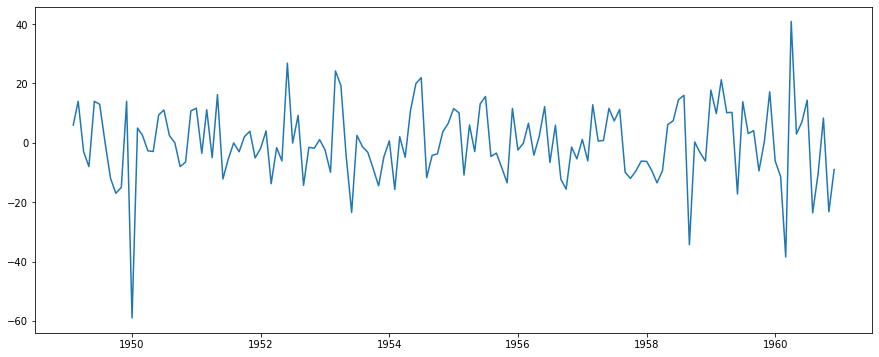

In [31]:
plt.figure(figsize=(15,6))
plt.plot(model3_fit.resid[1:])

(array([ 1.,  0.,  2.,  3., 24., 51., 33., 24.,  4.,  1.]),
 array([-59.00339024, -49.01357924, -39.02376825, -29.03395726,
        -19.04414626,  -9.05433527,   0.93547573,  10.92528672,
         20.91509771,  30.90490871,  40.8947197 ]),
 <BarContainer object of 10 artists>)

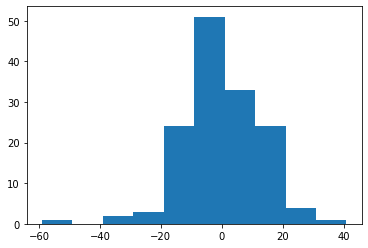

In [32]:
plt.hist(model3_fit.resid[1:])